In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SPADE VAE-GAN

This notebook creates a mock SPADE VAE-GAN based on the paper "Semantic Image Synthesis with Spatially-Adaptive Normalization" (2019) by Park T, Liu MY, Wang TC, Zhu JY. More information available at: https://github.com/NVlabs/SPADE

In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import zipfile
import gdown
from monai.data import DataLoader
from tqdm import tqdm
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import MultiScalePatchDiscriminator
import numpy as np
import monai
from generative.networks.nets.spade_network import SPADE_Net

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = Path(root_dir)
print("Temporary directory used: %s " % root_dir)

Temporary directory used: /tmp/tmpz0rbc_3s 


In [26]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 6
num_workers = 4
num_epochs = 100
lambda_perc = 1.0
lambda_feat = 0.1
lambda_kld = 0.00001
loss_adv = 1.0

### Data

The data for this notebook comes from the public dataset OASIS (Open Access Series of Imaging Studies) [1]. The images have been registered to MNI space using ANTsPy, and then subsampled to 2mm isotropic resolution. Geodesic Information Flows (GIF) [2] has been used to segment 5 regions: cerebrospinal fluid (CSF), grey matter (GM), white matter (WM), deep grey matter (DGM) and brainstem. In addition, BaMos [3] has been used to provide white matter hyperintensities segmentations (WMH). The available dataset contains:
- T1-weighted images
- FLAIR weighted images
- Segmentations with the following labels: 0 (background), 1 (CSF), 2 (GM), 3 (WM), 4 (DGM), 5 (brainstem) and 6 (WMH).

_**Acknowledgments**: "Data were provided by OASIS-3: Longitudinal Multimodal Neuroimaging: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P30 AG066444, P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.”_


Citations:

[1] Marcus, DS, Wang, TH, Parker, J, Csernansky, JG, Morris, JC, Buckner. Open Access Series of Imaging Studies (OASIS): Cross-Sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults, RL. Journal of Cognitive Neuroscience, 19, 1498-1507. doi: 10.1162/jocn.2007.19.9.1498

[2] Cardoso MJ, Modat M, Wolz R, Melbourne A, Cash D, Rueckert D, Ourselin S. Geodesic Information Flows: Spatially-Variant Graphs and Their Application to Segmentation and Fusion. IEEE Trans Med Imaging. 2015 Sep;34(9):1976-88. doi: 10.1109/TMI.2015.2418298. Epub 2015 Apr 14. PMID: 25879909.

[3] Fiford CM, Sudre CH, Pemberton H, Walsh P, Manning E, Malone IB, Nicholas J, Bouvy WH, Carmichael OT, Biessels GJ, Cardoso MJ, Barnes J; Alzheimer’s Disease Neuroimaging Initiative. Automated White Matter Hyperintensity Segmentation Using Bayesian Model Selection: Assessment and Correlations with Cognitive Change. Neuroinformatics. 2020 Jun;18(3):429-449. doi: 10.1007/s12021-019-09439-6. PMID: 32062817; PMCID: PMC7338814.


In [4]:
gdown.download(
    "https://drive.google.com/uc?export=download&id=1SX_MCzQe-vyq09QYxECk32wZ2vxp9rx5", str(root_dir / "data.zip")
)

Downloading...
From: https://drive.google.com/uc?export=download&id=1SX_MCzQe-vyq09QYxECk32wZ2vxp9rx5
To: /tmp/tmpz0rbc_3s/data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384M/384M [00:05<00:00, 67.0MB/s]


'/tmp/tmpz0rbc_3s/data.zip'

In [5]:
zip_obj = zipfile.ZipFile(os.path.join(root_dir, "data.zip"), "r")
zip_obj.extractall(root_dir)
images_T1 = root_dir / "OASIS_SMALL-SUBSET/T1"
images_FLAIR = root_dir / "OASIS_SMALL-SUBSET/FLAIR"
labels = root_dir / "OASIS_SMALL-SUBSET/Segmentations"

In [6]:
# We create the data dictionaries that we need
all_images = [os.path.join(images_T1, i) for i in os.listdir(images_T1)] + [
    os.path.join(images_FLAIR, i) for i in os.listdir(images_FLAIR)
]
np.random.shuffle(all_images)
corresponding_labels = [
    os.path.join(labels, i.split("/")[-1].replace(i.split("/")[-1].split("_")[0], "Parcellation")) for i in all_images
]
input_dict = [{"image": i, "label": corresponding_labels[ind]} for ind, i in enumerate(all_images)]
input_dict_train = input_dict[: int(len(input_dict) * 0.9)]
input_dict_val = input_dict[int(len(input_dict) * 0.9) :]

### Dataloaders

In [7]:
preliminar_shape = input_shape + [50]  # We take random slices fron the center of the brain
crop_shape = input_shape + [1]
base_transforms = [
    monai.transforms.LoadImaged(keys=["label", "image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.CenterSpatialCropd(keys=["label", "image"], roi_size=preliminar_shape),
    monai.transforms.RandSpatialCropd(keys=["label", "image"], roi_size=crop_shape, max_roi_size=crop_shape),
    monai.transforms.SqueezeDimd(keys=["label", "image"], dim=-1),
    monai.transforms.Resized(keys=["image", "label"], spatial_size=input_shape),
]
last_transforms = [
    monai.transforms.CopyItemsd(keys=["label"], names=["label_channel"]),
    monai.transforms.Lambdad(keys=["label_channel"], func=lambda l: l != 0),
    monai.transforms.MaskIntensityd(keys=["image"], mask_key="label_channel"),
    monai.transforms.NormalizeIntensityd(keys=["image"]),
    monai.transforms.ToTensord(keys=["image", "label"]),
]

aug_transforms = [
    monai.transforms.RandBiasFieldd(coeff_range=(0, 0.005), prob=0.33, keys=["image"]),
    monai.transforms.RandAdjustContrastd(gamma=(0.9, 1.15), prob=0.33, keys=["image"]),
    monai.transforms.RandGaussianNoised(prob=0.33, mean=0.0, std=np.random.uniform(0.005, 0.015), keys=["image"]),
    monai.transforms.RandAffined(
        rotate_range=[-0.05, 0.05],
        shear_range=[0.001, 0.05],
        scale_range=[0, 0.05],
        padding_mode="zeros",
        mode="nearest",
        prob=0.33,
        keys=["label", "image"],
    ),
]

train_transforms = monai.transforms.Compose(base_transforms + aug_transforms + last_transforms)
val_transforms = monai.transforms.Compose(base_transforms + last_transforms)

train_dataset = monai.data.dataset.Dataset(input_dict_train, train_transforms)
val_dataset = monai.data.dataset.Dataset(input_dict_val, val_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=num_workers)

torch.Size([6, 1, 128, 128])


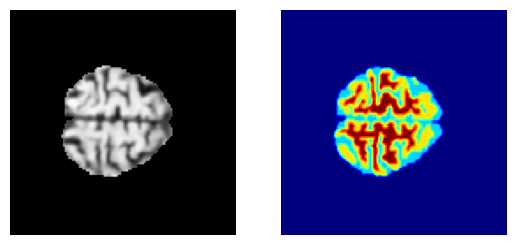

In [8]:
# Sanity check
batch = next(iter(train_loader))
print(batch["image"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["image"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["label"][0, 0, ...], cmap="jet")
plt.axis("off")
plt.show()

### Network creation and losses

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [11]:
def picture_results(input_label, input_image, output_image):
    f = plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Label")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

In [12]:
def feature_loss(input_features_disc_fake, input_features_disc_real, lambda_feat, device):
    criterion = torch.nn.L1Loss()
    num_D = len(input_features_disc_fake)
    GAN_Feat_loss = torch.zeros(1).to(device)
    for i in range(num_D):  # for each discriminator
        num_intermediate_outputs = len(input_features_disc_fake[i])
        for j in range(num_intermediate_outputs):  # for each layer output
            unweighted_loss = criterion(input_features_disc_fake[i][j], input_features_disc_real[i][j].detach())
            GAN_Feat_loss += unweighted_loss * lambda_feat / num_D
    return GAN_Feat_loss

In [13]:
net = SPADE_Net(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    label_nc=6,
    input_shape=input_shape,
    num_channels=[16, 32, 64, 128],
    z_dim=16,
    is_vae=True,
)

In [14]:
discriminator = MultiScalePatchDiscriminator(
    num_d=2,
    num_layers_d=3,
    spatial_dims=2,
    num_channels=8,
    in_channels=7,
    out_channels=7,
    minimum_size_im=128,
    norm="INSTANCE",
    kernel_size=3,
)

adversarial_loss = PatchAdversarialLoss(reduction="sum", criterion="hinge")

In [15]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="vgg", is_fake_3d=False, pretrained=True)
perceptual_loss = perceptual_loss.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


In [16]:
optimizer_G = torch.optim.Adam(net.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0004)

### Training loop


Epoch 0/100


  0%|                | 0/2 [00:00<?, ?it/s, kld=135, perceptual=0.246, generator=3.45, feature=0.126, discriminator=1.7]

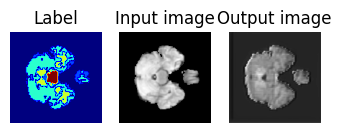

100%|██████| 2/2 [00:00<00:00,  3.22it/s, kld=63.6, perceptual=0.254, generator=3.38, feature=0.125, discriminator=1.77]

Epoch 1/100



100%|████████| 2/2 [00:00<00:00,  4.36it/s, kld=359, perceptual=0.36, generator=3.44, feature=0.173, discriminator=1.85]

Epoch 2/100



100%|████████| 2/2 [00:00<00:00,  4.07it/s, kld=346, perceptual=0.34, generator=3.57, feature=0.167, discriminator=1.63]

Epoch 3/100



100%|███████| 2/2 [00:00<00:00,  4.36it/s, kld=262, perceptual=0.325, generator=3.49, feature=0.164, discriminator=1.63]

Epoch 4/100



100%|███████| 2/2 [00:00<00:00,  4.45it/s, kld=101, perceptual=0.307, generator=3.58, feature=0.164, discriminator=1.65]

Epoch 5/100



100%|██████| 2/2 [00:00<00:00,  3.79it/s, kld=68.9, perceptual=0.288, generator=3.58, feature=0.165, discriminator=1.61]

Epoch 6/100



100%|████████| 2/2 [00:00<00:00,  4.25it/s, kld=80, perceptual=0.278, generator=3.59, feature=0.161, discriminator=1.51]

Epoch 7/100



100%|█████████| 2/2 [00:00<00:00,  4.44it/s, kld=73.9, perceptual=0.269, generator=3.6, feature=0.16, discriminator=1.5]

Epoch 8/100



100%|█████████| 2/2 [00:00<00:00,  4.31it/s, kld=54.1, perceptual=0.26, generator=3.6, feature=0.154, discriminator=1.5]

Epoch 9/100



100%|██████| 2/2 [00:00<00:00,  4.01it/s, kld=69.7, perceptual=0.252, generator=3.62, feature=0.141, discriminator=1.46]

Epoch 10/100



  0%|               | 0/2 [00:00<?, ?it/s, kld=176, perceptual=0.259, generator=3.51, feature=0.126, discriminator=1.64]

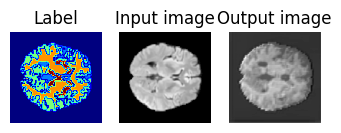

100%|████████| 2/2 [00:00<00:00,  3.42it/s, kld=109, perceptual=0.258, generator=3.54, feature=0.128, discriminator=1.6]

Epoch 11/100



100%|███████| 2/2 [00:00<00:00,  3.80it/s, kld=252, perceptual=0.325, generator=3.39, feature=0.141, discriminator=1.88]

Epoch 12/100



100%|████████| 2/2 [00:00<00:00,  4.29it/s, kld=214, perceptual=0.317, generator=3.57, feature=0.17, discriminator=1.61]

Epoch 13/100



100%|███████| 2/2 [00:00<00:00,  4.01it/s, kld=53.1, perceptual=0.314, generator=3.58, feature=0.176, discriminator=1.5]

Epoch 14/100



100%|████████| 2/2 [00:00<00:00,  4.45it/s, kld=83.5, perceptual=0.295, generator=3.6, feature=0.17, discriminator=1.47]

Epoch 15/100



100%|███████| 2/2 [00:00<00:00,  4.49it/s, kld=38.9, perceptual=0.285, generator=3.6, feature=0.166, discriminator=1.47]

Epoch 16/100



100%|███████| 2/2 [00:00<00:00,  4.36it/s, kld=80.4, perceptual=0.246, generator=3.6, feature=0.159, discriminator=1.47]

Epoch 17/100



100%|████████| 2/2 [00:00<00:00,  4.44it/s, kld=60, perceptual=0.233, generator=3.51, feature=0.166, discriminator=1.59]

Epoch 18/100



100%|███████| 2/2 [00:00<00:00,  2.86it/s, kld=181, perceptual=0.251, generator=3.59, feature=0.172, discriminator=1.53]

Epoch 19/100



100%|██████| 2/2 [00:00<00:00,  4.42it/s, kld=483, perceptual=0.304, generator=2.73, feature=0.0971, discriminator=2.46]

Epoch 20/100



  0%|               | 0/2 [00:00<?, ?it/s, kld=805, perceptual=0.356, generator=3.32, feature=0.148, discriminator=1.71]

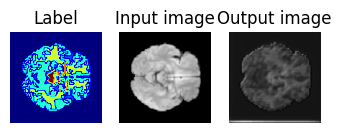

100%|███████| 2/2 [00:00<00:00,  2.95it/s, kld=530, perceptual=0.346, generator=3.16, feature=0.143, discriminator=1.94]

Epoch 21/100



100%|██████| 2/2 [00:00<00:00,  4.35it/s, kld=80.1, perceptual=0.399, generator=3.61, feature=0.225, discriminator=1.44]

Epoch 22/100



100%|██████| 2/2 [00:00<00:00,  4.43it/s, kld=91.7, perceptual=0.366, generator=3.62, feature=0.217, discriminator=1.38]

Epoch 23/100



100%|████████| 2/2 [00:00<00:00,  4.46it/s, kld=216, perceptual=0.311, generator=3.6, feature=0.185, discriminator=1.48]

Epoch 24/100



100%|███████| 2/2 [00:00<00:00,  4.07it/s, kld=136, perceptual=0.269, generator=3.59, feature=0.168, discriminator=1.52]

Epoch 25/100



100%|███████| 2/2 [00:00<00:00,  4.41it/s, kld=220, perceptual=0.272, generator=3.61, feature=0.156, discriminator=1.45]

Epoch 26/100



100%|███████| 2/2 [00:00<00:00,  4.00it/s, kld=117, perceptual=0.246, generator=3.59, feature=0.157, discriminator=1.52]

Epoch 27/100



100%|███████| 2/2 [00:00<00:00,  4.47it/s, kld=120, perceptual=0.256, generator=3.61, feature=0.156, discriminator=1.43]

Epoch 28/100



100%|██████| 2/2 [00:00<00:00,  4.35it/s, kld=76.3, perceptual=0.248, generator=3.61, feature=0.153, discriminator=1.41]

Epoch 29/100



100%|███████| 2/2 [00:00<00:00,  4.18it/s, kld=98.1, perceptual=0.228, generator=3.6, feature=0.149, discriminator=1.43]

Epoch 30/100



  0%|                | 0/2 [00:00<?, ?it/s, kld=134, perceptual=0.217, generator=3.63, feature=0.143, discriminator=1.4]

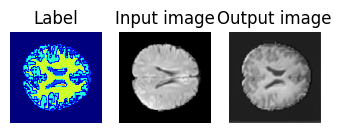

100%|█████████| 2/2 [00:00<00:00,  3.31it/s, kld=90, perceptual=0.226, generator=3.6, feature=0.142, discriminator=1.43]

Epoch 31/100



100%|██████| 2/2 [00:00<00:00,  4.38it/s, kld=62.7, perceptual=0.212, generator=3.64, feature=0.144, discriminator=1.32]

Epoch 32/100



100%|██████| 2/2 [00:00<00:00,  4.42it/s, kld=89.2, perceptual=0.233, generator=3.63, feature=0.143, discriminator=1.36]

Epoch 33/100



100%|██████| 2/2 [00:00<00:00,  4.19it/s, kld=70.7, perceptual=0.226, generator=3.61, feature=0.144, discriminator=1.41]

Epoch 34/100



100%|██████| 2/2 [00:00<00:00,  4.08it/s, kld=77.5, perceptual=0.204, generator=3.62, feature=0.145, discriminator=1.37]

Epoch 35/100



100%|██████| 2/2 [00:00<00:00,  4.23it/s, kld=72.3, perceptual=0.219, generator=3.58, feature=0.146, discriminator=1.42]

Epoch 36/100



100%|██████| 2/2 [00:00<00:00,  4.47it/s, kld=98.9, perceptual=0.222, generator=3.63, feature=0.145, discriminator=1.42]

Epoch 37/100



100%|███████| 2/2 [00:00<00:00,  4.23it/s, kld=142, perceptual=0.217, generator=3.58, feature=0.148, discriminator=1.45]

Epoch 38/100



100%|██████| 2/2 [00:00<00:00,  4.44it/s, kld=66.2, perceptual=0.211, generator=3.63, feature=0.145, discriminator=1.35]

Epoch 39/100



100%|██████| 2/2 [00:00<00:00,  3.83it/s, kld=74.2, perceptual=0.202, generator=3.62, feature=0.143, discriminator=1.38]

Epoch 40/100



  0%|              | 0/2 [00:00<?, ?it/s, kld=93.6, perceptual=0.217, generator=3.63, feature=0.143, discriminator=1.33]

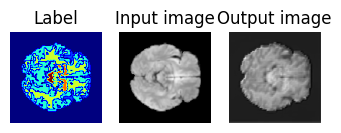

100%|██████| 2/2 [00:00<00:00,  3.33it/s, kld=86.4, perceptual=0.205, generator=3.63, feature=0.142, discriminator=1.36]

Epoch 41/100



100%|██████| 2/2 [00:00<00:00,  3.98it/s, kld=73.5, perceptual=0.197, generator=3.62, feature=0.141, discriminator=1.35]

Epoch 42/100



100%|██████| 2/2 [00:00<00:00,  4.48it/s, kld=55.8, perceptual=0.207, generator=3.63, feature=0.136, discriminator=1.33]

Epoch 43/100



100%|██████| 2/2 [00:00<00:00,  4.34it/s, kld=57.2, perceptual=0.209, generator=3.66, feature=0.135, discriminator=1.25]

Epoch 44/100



100%|██████| 2/2 [00:00<00:00,  3.98it/s, kld=82.2, perceptual=0.182, generator=3.62, feature=0.124, discriminator=1.35]

Epoch 45/100



100%|██████| 2/2 [00:00<00:00,  4.10it/s, kld=72.3, perceptual=0.195, generator=3.64, feature=0.132, discriminator=1.29]

Epoch 46/100



100%|██████| 2/2 [00:00<00:00,  4.20it/s, kld=60.3, perceptual=0.213, generator=3.65, feature=0.129, discriminator=1.27]

Epoch 47/100



100%|██████| 2/2 [00:00<00:00,  4.34it/s, kld=59.4, perceptual=0.202, generator=3.66, feature=0.125, discriminator=1.26]

Epoch 48/100



100%|███████| 2/2 [00:00<00:00,  4.31it/s, kld=55.1, perceptual=0.21, generator=3.64, feature=0.134, discriminator=1.29]

Epoch 49/100



100%|████████| 2/2 [00:00<00:00,  4.29it/s, kld=63.5, perceptual=0.2, generator=3.61, feature=0.131, discriminator=1.35]

Epoch 50/100



  0%|              | 0/2 [00:00<?, ?it/s, kld=92.4, perceptual=0.198, generator=3.63, feature=0.134, discriminator=1.32]

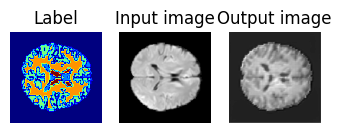

100%|██████| 2/2 [00:00<00:00,  3.45it/s, kld=52.4, perceptual=0.203, generator=3.65, feature=0.133, discriminator=1.27]

Epoch 51/100



100%|███████| 2/2 [00:00<00:00,  4.27it/s, kld=50.3, perceptual=0.207, generator=3.64, feature=0.133, discriminator=1.3]

Epoch 52/100



100%|██████| 2/2 [00:00<00:00,  4.32it/s, kld=65.7, perceptual=0.182, generator=3.62, feature=0.128, discriminator=1.35]

Epoch 53/100



100%|██████| 2/2 [00:00<00:00,  4.45it/s, kld=67.2, perceptual=0.176, generator=3.63, feature=0.129, discriminator=1.32]

Epoch 54/100



100%|██████| 2/2 [00:00<00:00,  4.49it/s, kld=43.8, perceptual=0.204, generator=3.64, feature=0.133, discriminator=1.28]

Epoch 55/100



100%|███████| 2/2 [00:00<00:00,  4.44it/s, kld=71.7, perceptual=0.195, generator=3.6, feature=0.141, discriminator=1.37]

Epoch 56/100



100%|██████| 2/2 [00:00<00:00,  4.18it/s, kld=64.4, perceptual=0.188, generator=3.62, feature=0.133, discriminator=1.33]

Epoch 57/100



100%|██████| 2/2 [00:00<00:00,  4.54it/s, kld=54.1, perceptual=0.201, generator=3.59, feature=0.136, discriminator=1.36]

Epoch 58/100



100%|██████| 2/2 [00:00<00:00,  4.09it/s, kld=64.9, perceptual=0.198, generator=3.63, feature=0.133, discriminator=1.32]

Epoch 59/100



100%|██████| 2/2 [00:00<00:00,  3.47it/s, kld=48.4, perceptual=0.187, generator=3.65, feature=0.132, discriminator=1.26]

Epoch 60/100



  0%|                | 0/2 [00:00<?, ?it/s, kld=84, perceptual=0.175, generator=3.62, feature=0.127, discriminator=1.31]

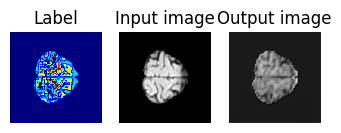

100%|██████| 2/2 [00:00<00:00,  3.59it/s, kld=45.9, perceptual=0.196, generator=3.65, feature=0.133, discriminator=1.26]

Epoch 61/100



100%|██████| 2/2 [00:00<00:00,  4.30it/s, kld=51.4, perceptual=0.175, generator=3.63, feature=0.127, discriminator=1.29]

Epoch 62/100



100%|██████| 2/2 [00:00<00:00,  4.25it/s, kld=51.4, perceptual=0.179, generator=3.59, feature=0.133, discriminator=1.36]

Epoch 63/100



100%|██████| 2/2 [00:00<00:00,  3.02it/s, kld=69.2, perceptual=0.195, generator=3.62, feature=0.135, discriminator=1.33]

Epoch 64/100



100%|██████| 2/2 [00:00<00:00,  4.46it/s, kld=67.6, perceptual=0.206, generator=3.65, feature=0.128, discriminator=1.27]

Epoch 65/100



100%|██████| 2/2 [00:00<00:00,  3.91it/s, kld=47.8, perceptual=0.198, generator=3.63, feature=0.133, discriminator=1.28]

Epoch 66/100



100%|███████| 2/2 [00:00<00:00,  4.20it/s, kld=62.5, perceptual=0.172, generator=3.63, feature=0.134, discriminator=1.3]

Epoch 67/100



100%|██████| 2/2 [00:00<00:00,  4.25it/s, kld=48.4, perceptual=0.196, generator=3.64, feature=0.135, discriminator=1.28]

Epoch 68/100



100%|██████| 2/2 [00:00<00:00,  4.05it/s, kld=61.3, perceptual=0.208, generator=3.65, feature=0.135, discriminator=1.27]

Epoch 69/100



100%|████████| 2/2 [00:00<00:00,  4.46it/s, kld=68, perceptual=0.188, generator=3.64, feature=0.132, discriminator=1.29]

Epoch 70/100



  0%|               | 0/2 [00:00<?, ?it/s, kld=94.5, perceptual=0.18, generator=3.62, feature=0.133, discriminator=1.32]

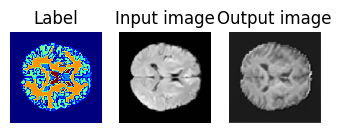

100%|███████| 2/2 [00:00<00:00,  3.44it/s, kld=54.3, perceptual=0.17, generator=3.64, feature=0.126, discriminator=1.29]

Epoch 71/100



100%|██████| 2/2 [00:00<00:00,  4.29it/s, kld=63.4, perceptual=0.191, generator=3.66, feature=0.131, discriminator=1.25]

Epoch 72/100



100%|███████| 2/2 [00:00<00:00,  4.33it/s, kld=77.6, perceptual=0.165, generator=3.64, feature=0.13, discriminator=1.27]

Epoch 73/100



100%|██████| 2/2 [00:00<00:00,  4.36it/s, kld=64.2, perceptual=0.204, generator=3.64, feature=0.137, discriminator=1.29]

Epoch 74/100



100%|██████| 2/2 [00:00<00:00,  4.13it/s, kld=50.9, perceptual=0.206, generator=3.65, feature=0.131, discriminator=1.26]

Epoch 75/100



100%|███████| 2/2 [00:00<00:00,  4.15it/s, kld=44.3, perceptual=0.182, generator=3.58, feature=0.13, discriminator=1.34]

Epoch 76/100



100%|████████| 2/2 [00:00<00:00,  4.08it/s, kld=95, perceptual=0.205, generator=3.63, feature=0.138, discriminator=1.31]

Epoch 77/100



100%|███████| 2/2 [00:00<00:00,  4.41it/s, kld=56.1, perceptual=0.203, generator=3.63, feature=0.138, discriminator=1.3]

Epoch 78/100



100%|███████| 2/2 [00:00<00:00,  4.19it/s, kld=56.4, perceptual=0.19, generator=3.64, feature=0.136, discriminator=1.26]

Epoch 79/100



100%|███████| 2/2 [00:00<00:00,  4.33it/s, kld=55.7, perceptual=0.17, generator=3.65, feature=0.128, discriminator=1.24]

Epoch 80/100



  0%|               | 0/2 [00:00<?, ?it/s, kld=122, perceptual=0.175, generator=3.64, feature=0.135, discriminator=1.28]

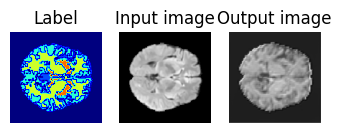

100%|██████| 2/2 [00:00<00:00,  3.51it/s, kld=62.6, perceptual=0.191, generator=3.66, feature=0.132, discriminator=1.24]

Epoch 81/100



100%|███████| 2/2 [00:00<00:00,  4.39it/s, kld=64.2, perceptual=0.197, generator=3.66, feature=0.13, discriminator=1.24]

Epoch 82/100



100%|██████| 2/2 [00:00<00:00,  4.01it/s, kld=61.5, perceptual=0.199, generator=3.67, feature=0.131, discriminator=1.23]

Epoch 83/100



100%|██████| 2/2 [00:00<00:00,  4.12it/s, kld=61.7, perceptual=0.181, generator=3.66, feature=0.123, discriminator=1.25]

Epoch 84/100



100%|███████| 2/2 [00:00<00:00,  4.47it/s, kld=46.8, perceptual=0.178, generator=3.65, feature=0.13, discriminator=1.26]

Epoch 85/100



100%|███████| 2/2 [00:00<00:00,  4.30it/s, kld=66.1, perceptual=0.19, generator=3.63, feature=0.133, discriminator=1.29]

Epoch 86/100



100%|████████| 2/2 [00:00<00:00,  4.41it/s, kld=72, perceptual=0.208, generator=3.62, feature=0.141, discriminator=1.32]

Epoch 87/100



100%|██████| 2/2 [00:00<00:00,  4.19it/s, kld=81.4, perceptual=0.176, generator=3.63, feature=0.133, discriminator=1.28]

Epoch 88/100



100%|███████| 2/2 [00:00<00:00,  4.28it/s, kld=54.9, perceptual=0.192, generator=3.63, feature=0.136, discriminator=1.3]

Epoch 89/100



100%|██████| 2/2 [00:00<00:00,  4.18it/s, kld=85.9, perceptual=0.173, generator=3.64, feature=0.129, discriminator=1.28]

Epoch 90/100



  0%|               | 0/2 [00:00<?, ?it/s, kld=99.1, perceptual=0.18, generator=3.64, feature=0.134, discriminator=1.28]

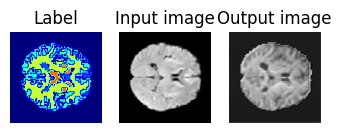

100%|██████| 2/2 [00:00<00:00,  3.52it/s, kld=50.1, perceptual=0.159, generator=3.65, feature=0.126, discriminator=1.28]

Epoch 91/100



100%|██████| 2/2 [00:00<00:00,  3.88it/s, kld=54.5, perceptual=0.193, generator=3.64, feature=0.136, discriminator=1.27]

Epoch 92/100



100%|██████| 2/2 [00:00<00:00,  4.22it/s, kld=56.2, perceptual=0.163, generator=3.66, feature=0.129, discriminator=1.24]

Epoch 93/100



100%|██████| 2/2 [00:00<00:00,  4.38it/s, kld=63.8, perceptual=0.192, generator=3.66, feature=0.131, discriminator=1.24]

Epoch 94/100



100%|██████| 2/2 [00:00<00:00,  4.20it/s, kld=62.4, perceptual=0.158, generator=3.63, feature=0.124, discriminator=1.29]

Epoch 95/100



100%|██████| 2/2 [00:00<00:00,  4.25it/s, kld=72.7, perceptual=0.161, generator=3.64, feature=0.126, discriminator=1.28]

Epoch 96/100



100%|████████| 2/2 [00:00<00:00,  4.27it/s, kld=76, perceptual=0.166, generator=3.65, feature=0.128, discriminator=1.27]

Epoch 97/100



100%|███████| 2/2 [00:00<00:00,  3.91it/s, kld=52.8, perceptual=0.16, generator=3.64, feature=0.122, discriminator=1.27]

Epoch 98/100



100%|██████| 2/2 [00:00<00:00,  4.30it/s, kld=66.9, perceptual=0.182, generator=3.66, feature=0.131, discriminator=1.22]

Epoch 99/100



100%|███████| 2/2 [00:00<00:00,  3.99it/s, kld=63.3, perceptual=0.16, generator=3.66, feature=0.129, discriminator=1.25]


In [27]:
net = net.to(device)
discriminator = discriminator.to(device)
torch.autograd.set_detect_anomaly(True)
losses = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
losses_val = {"kld": [], "perceptual": [], "feature": [], "generator": [], "discriminator": []}
for epoch in range(num_epochs):
    print("Epoch %d/%d" % (epoch, num_epochs))
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=120)
    losses_epoch = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for step, d in train_bar:
        image = d["image"].to(device)
        with torch.no_grad():
            label = one_hot(d["label"], 6).to(device)
        optimizer_G.zero_grad()

        # Losses gen
        out, kld_loss = net(label, image)
        disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
        loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
        disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
        loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
        loss_perc = perceptual_loss(out, target=image)
        total_loss = loss_g + loss_perc * lambda_perc + kld_loss * lambda_kld + loss_feat * lambda_feat
        total_loss.backward(retain_graph=True)
        optimizer_G.step()

        # Store
        losses_epoch["kld"] += kld_loss.item()
        losses_epoch["perceptual"] += loss_perc.item()
        losses_epoch["generator"] += loss_g.item()
        # Train disc
        out, _ = net(label, image)
        disc_fakes, _ = discriminator(torch.cat([out, label], 1))
        loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
        loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
        optimizer_D.zero_grad()
        loss_d = loss_d_r + loss_g_f
        loss_d.backward()
        optimizer_D.step()

        # Store
        losses_epoch["feature"] = loss_feat.item()
        losses_epoch["discriminator"] = loss_d_r.item() + loss_g_f.item()

        train_bar.set_postfix(
            {
                "kld": kld_loss.item(),
                "perceptual": loss_perc.item(),
                "generator": loss_g.item(),
                "feature": loss_feat.item(),
                "discriminator": loss_d_r.item() + loss_g_f.item(),
            }
        )

    val_bar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=120)
    losses_epoch_val = {"kld": 0, "perceptual": 0, "feature": 0, "generator": 0, "discriminator": 0}
    for step, d in val_bar:
        image = d["image"].to(device)
        with torch.no_grad():
            label = one_hot(d["label"], 6).to(device)
            # Losses gen
            out, kld_loss = net(label, image)
            disc_fakes, features_fakes = discriminator(torch.cat([out, label], 1))
            loss_g = adversarial_loss(disc_fakes, target_is_real=True, for_discriminator=False)
            disc_reals, features_reals = discriminator(torch.cat([image, label], 1))
            loss_feat = feature_loss(features_fakes, features_reals, lambda_feat, device)
            loss_perc = perceptual_loss(out, target=image)
            total_loss = loss_adv * loss_g + loss_perc * lambda_perc + kld_loss * lambda_kld + loss_feat * lambda_feat
            # Store
            losses_epoch_val["kld"] += kld_loss.item()
            losses_epoch_val["perceptual"] += loss_perc.item()
            losses_epoch_val["generator"] += loss_g.item()
            # Train disc
            out, _ = net(label, image)
            disc_fakes, _ = discriminator(torch.cat([out, label], 1))
            loss_d_r = adversarial_loss(disc_reals, target_is_real=True, for_discriminator=True)
            loss_g_f = adversarial_loss(disc_fakes, target_is_real=False, for_discriminator=True)
            loss_d = loss_adv * (loss_d_r + loss_g_f)

            # Store
            losses_epoch_val["feature"] = loss_feat.item()
            losses_epoch_val["discriminator"] = loss_d_r.item() + loss_g_f.item()

            val_bar.set_postfix(
                {
                    "kld": kld_loss.item(),
                    "perceptual": loss_perc.item(),
                    "generator": loss_g.item(),
                    "feature": loss_feat.item(),
                    "discriminator": loss_d_r.item() + loss_g_f.item(),
                }
            )
            if step == 0 and epoch % 10 == 0:
                picture_results(label, image, out)
    for key, val in losses_epoch.items():
        losses[key].append(val / len(train_loader))
    for key, val in losses_epoch_val.items():
        losses_val[key].append(val / len(val_loader))

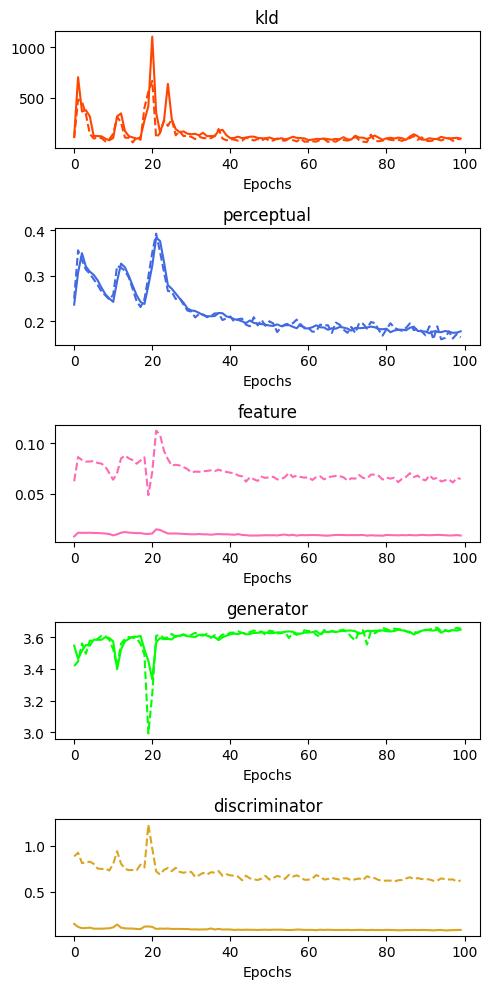

In [28]:
# Plot losses
colors = ["orangered", "royalblue", "hotpink", "lime", "goldenrod"]
plt.figure(figsize=(5, 10))
ind = 0
for key, val in losses.items():
    plt.subplot(len(losses.keys()), 1, ind + 1)
    plt.plot(val, color=colors[ind], linestyle="-")
    plt.plot(losses_val[key], color=colors[ind], linestyle="--")
    plt.title(key)
    plt.xlabel("Epochs")
    ind += 1
plt.tight_layout()
plt.show()

**Conclusion**: from early on, the network shows the capability of discern between the different semantic layers. To achieve good image quality, more images and training time are needed (to avoid overfitting, seen in some loss plots of previous example), as well as thorough optimisation, such as establishing an adversarial schedule that makes sure that the discriminator and generator and the discriminator are trained only when their performance does not exceed a certain limit.
